In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import time
import math
%matplotlib inline

In [2]:
df = pd.read_csv('lublin-listings.csv', index_col = 0)

In [3]:
df_convenience = pd.read_csv('convenience-stores-lublin.csv', index_col = 0)

In [4]:
df.head()

,location,name,price,space,latitude,longitude
0,"Lublin, Dziesiąta, Nowy Świat 37","48,5 m2, ul. Nowy Świat, 2 Pok. BEZPOŚREDNIO",1100.0,48.5,51.224689,22.558730
1,"Lublin, Czechów Górny",Wyremontowane 2 pok. mieszkanie Chodźki blisko Um,1500.0,50.0,51.263611,22.539445
2,"Lublin, Leszka",Atrakcyjne mieszkanie 4pokojowe,1800.0,85.0,51.249653,22.488240
3,"Lublin, Czuby, Jaspisowa","Mieszkanie, 66 m², Lublin",2000.0,-1.0,-1.000000,-1.000000
4,"Lublin, LSM, Pielgrzymia","2-pokojowe mieszkanie, Lublin Lsm, ul. Pielgrz...",1500.0,44.0,-1.000000,-1.000000


In [5]:
df_convenience.head()

,type,latitude,longitude
0,lidl,51.26647,22.51458
1,lidl,51.25822,22.58331
2,lidl,51.22974,22.59785
3,lidl,51.25139,22.58149
4,lidl,51.22351,22.57385


In [6]:
sns.set(style="white", context="talk")

In [7]:
# calculate shortes path on globe between 2 points on a sphere

def get_distance(lat,long,target_lat,target_long):
    """
    How to compute the distance between 2 geografical coordinates: https://www.movable-type.co.uk/scripts/latlong.html
    """
    R = 6371e3
    fi1 = math.radians(lat)
    fi2 = math.radians(target_lat)
    d_fi = math.radians(target_lat-lat)
    d_lambda = math.radians(target_long-long)
    
    a = (math.sin(d_fi / 2))**2 + (math.cos(fi1) * math.cos(fi2) * (math.sin(d_lambda/2))**2)
    c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    d = math.modf(R * c)[1]
    
    return d

In [8]:
df.describe()

,price,space,latitude,longitude
count,589.000000,589.000000,589.000000,589.000000
mean,2166.779287,61.077912,41.163457,18.038867
std,780.241114,23.004137,20.787602,9.388000
min,400.000000,-1.000000,-1.000000,-1.000000
25%,1650.000000,48.000000,51.224689,22.517639
50%,2000.000000,58.000000,51.250317,22.552050
75%,2500.000000,70.000000,51.266203,22.576946
max,6000.000000,175.000000,52.174766,23.418754


In [9]:
colors = ["#2035f7","#21ddff","#13f93e","#f9b027","#ff1d00"]

In [10]:
price_cat = []
for row in df.itertuples():
    price = row.price
    if price <= 1000:
        price_cat.append("cat_1")
    elif price <= 2000:
        price_cat.append("cat_2")
    elif price <= 2500:
        price_cat.append("cat_3")
    elif price <= 3000:
        price_cat.append("cat_4")
    elif price > 3000:
        price_cat.append("cat_5")
df['price_cat'] = pd.Series(price_cat, index=df.index)

In [11]:
df.groupby(['price_cat']).size()

price_cat
cat_1     18
cat_2    305
cat_3    135
cat_4     65
cat_5     66
dtype: int64

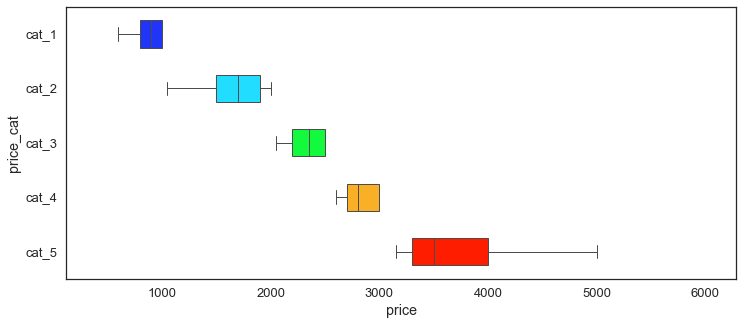

In [12]:
plt.figure(figsize=(12,5))
sns.boxplot(x="price", y="price_cat", data=df,width=0.5,
            linewidth=1,fliersize=0.0,palette=colors,
            saturation=1,
            order=["cat_1","cat_2","cat_3","cat_4","cat_5"]
           )

In [13]:
space_list = []
for row in df.itertuples():
    space = str(row.space)
    if space.find(','):
        space = space.replace(',','.')
        space = float(space)
    else:
        space = float(space)
    space_list.append(space)
    
    
df['space'] = pd.Series(space_list, index=df.index)

In [14]:
df = df.loc[df['latitude'] != -1]
df = df.loc[df['space'] != -1]
df.describe()

,price,space,latitude,longitude
count,470.000000,470.000000,470.000000,470.000000
mean,2179.838298,62.682872,51.394289,22.659030
std,810.569149,23.147002,0.313352,0.228918
min,400.000000,12.000000,50.453399,22.372554
25%,1650.000000,48.000000,51.246662,22.535651
50%,2000.000000,59.250000,51.256428,22.558350
75%,2500.000000,72.000000,51.272020,22.584858
max,6000.000000,175.000000,52.174766,23.418754


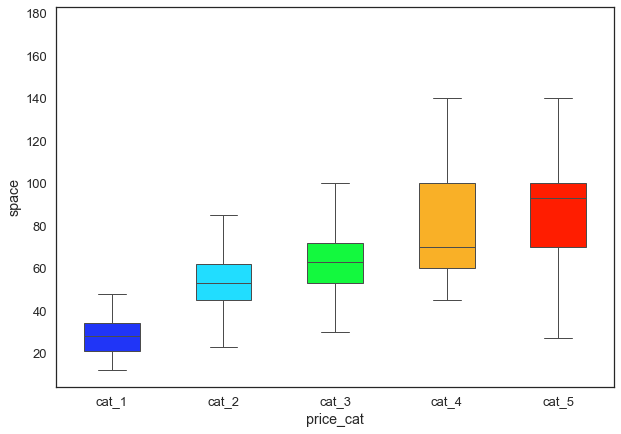

In [15]:
plt.figure(figsize=(10,7))
sns.boxplot(x="price_cat", y="space", data=df,width=0.5,
            linewidth=1,fliersize=0.0,palette=colors,
            saturation=1,orient="v",
            order=["cat_1","cat_2","cat_3","cat_4","cat_5"]
           )

In [16]:
dist_to_center = []
for row in df.itertuples():
    lat = row.latitude
    long = row.longitude
    dist_to_center.append(get_distance(lat,long,target_lat = 51.25,target_long = 22.56667))
    
    
df['dist_to_center'] = pd.Series(dist_to_center, index=df.index)

In [17]:
min_shop_dist = []
min_shop_type = []
for row in df.itertuples():
    lat = row.latitude
    long = row.longitude
    min_dist = 10e5
    shop_type = "none"
    for i in df_convenience.itertuples():
        shop_lat = i.latitude
        shop_long = i.longitude
        dist = great_circle((lat,long),(shop_lat,shop_long)).meters
        if dist < min_dist:
            min_dist = dist
            shop_type = i.type
    min_shop_dist.append(math.modf(min_dist)[1])
    min_shop_type.append(shop_type)
    
df['shop_dist'] = pd.Series(min_shop_dist, index=df.index)
df['shop_type'] = pd.Series(min_shop_type, index=df.index)

In [18]:
df = df.loc[df['shop_dist'] <= 1e4]
df.head()

,location,name,price,space,latitude,longitude,price_cat,dist_to_center,shop_dist,shop_type
0,"Lublin, Dziesiąta, Nowy Świat 37","48,5 m2, ul. Nowy Świat, 2 Pok. BEZPOŚREDNIO",1100.0,48.5,51.224689,22.558730,cat_2,2868.0,1061.0,lidl
1,"Lublin, Czechów Górny",Wyremontowane 2 pok. mieszkanie Chodźki blisko Um,1500.0,50.0,51.263611,22.539445,cat_2,2424.0,847.0,lidl
2,"Lublin, Leszka",Atrakcyjne mieszkanie 4pokojowe,1800.0,85.0,51.249653,22.488240,cat_2,5458.0,2135.0,zabka
6,"Lublin, Śródmieście, Spokojna",Ekskluzywny apartament w centrum miasta,3300.0,93.0,51.250317,22.553738,cat_5,900.0,668.0,zabka
8,"Lublin, Sławinek, Dzieci Zamojszczyzny","Mieszkanie, 16 m², Lublin",595.0,16.0,51.255633,22.512604,cat_1,3814.0,331.0,zabka


In [19]:
df.describe()

,price,space,latitude,longitude,dist_to_center,shop_dist
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,2149.031746,61.591455,51.251131,22.550162,2389.812169,647.806878
std,774.671108,22.000130,0.016079,0.025783,1424.092595,503.070621
min,595.000000,15.000000,51.195316,22.484171,142.000000,48.000000
25%,1650.000000,48.125000,51.243516,22.529209,1172.000000,348.000000
50%,2000.000000,57.500000,51.250629,22.554731,2422.000000,540.000000
75%,2500.000000,70.000000,51.263611,22.568841,3134.500000,847.000000
max,6000.000000,165.000000,51.287644,22.679190,8975.000000,6052.000000


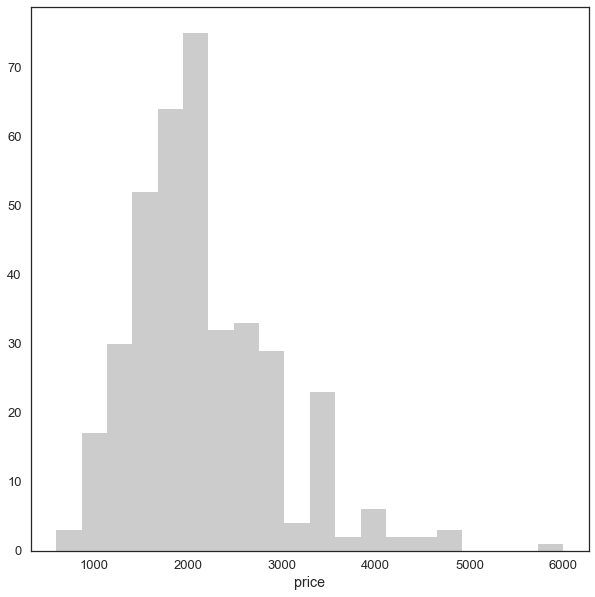

In [20]:
plt.figure(figsize=(10,10))
sns.distplot(df['price'], bins=20, kde=False, color="gray")

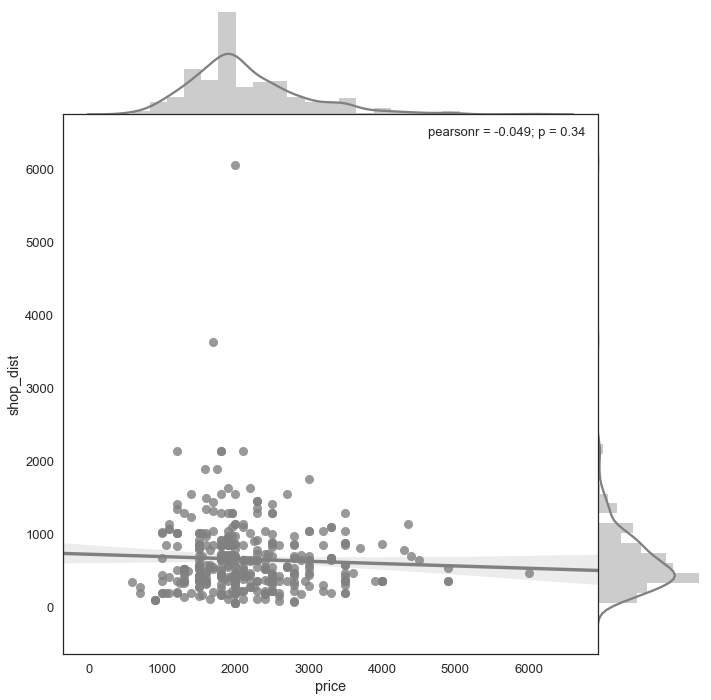

In [21]:
sns.jointplot(x=df.price, y=df.shop_dist, kind="reg",size=10, space=0, color="gray")

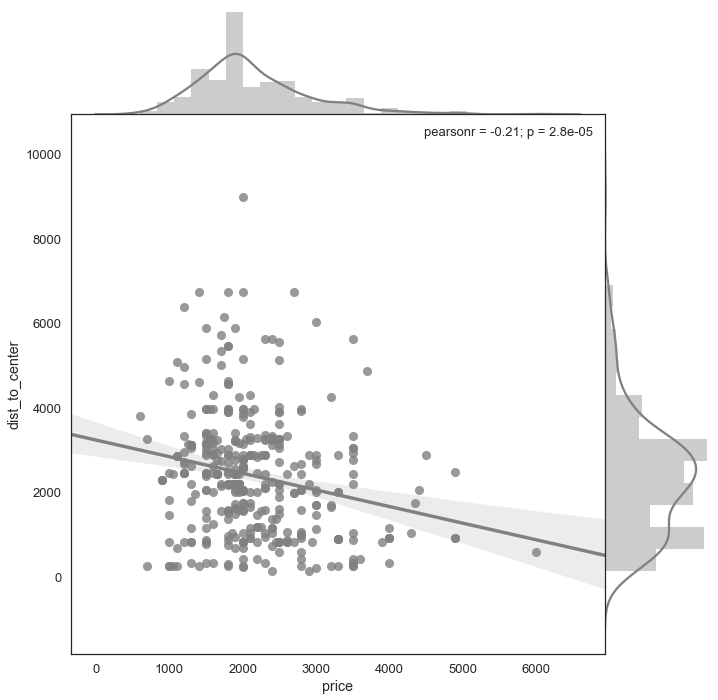

In [22]:
sns.jointplot(x=df.price, y=df.dist_to_center, kind="reg",size=10, space=0, color="gray")

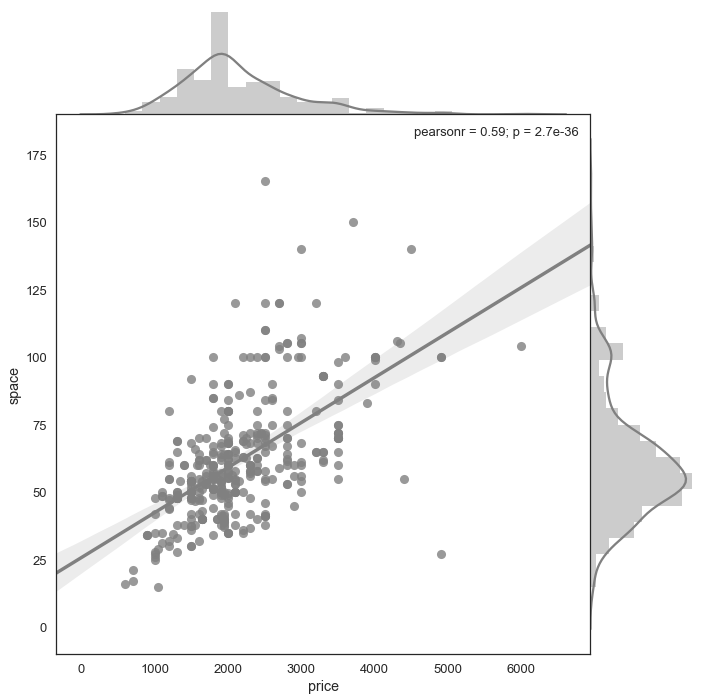

In [23]:
sns.jointplot(x=df.price, y=df.space, kind="reg",size=10, space=0, color="gray")

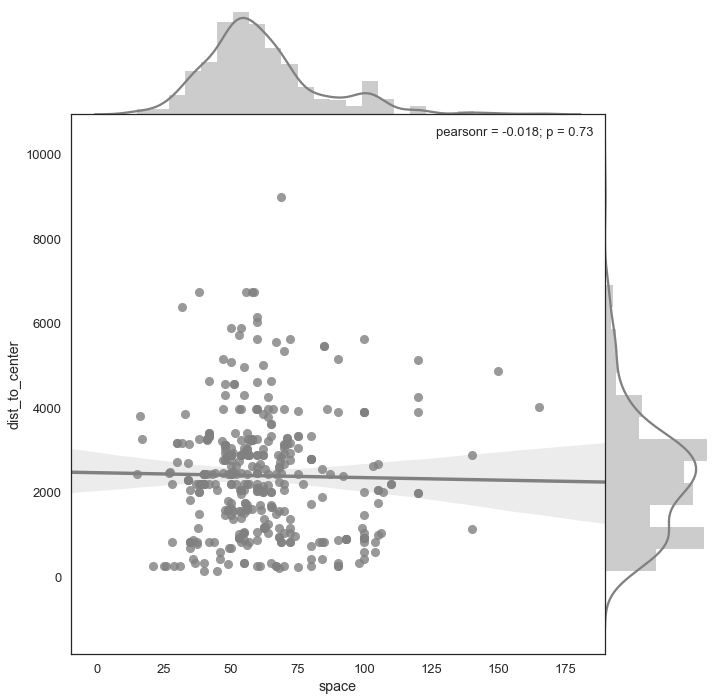

In [24]:
sns.jointplot(x=df.space, y=df.dist_to_center, kind="reg",size=10, space=0, color="gray")

In [25]:
df = df.loc[df['dist_to_center'] <= 3000]
df = df.loc[df['shop_dist'] <= 1000]
df.describe()

,price,space,latitude,longitude,dist_to_center,shop_dist
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,2263.855263,62.246360,51.253798,22.555975,1613.732456,503.311404
std,830.265438,21.907035,0.009542,0.017697,872.524048,229.056953
min,700.000000,15.000000,51.227919,22.526111,142.000000,48.000000
25%,1800.000000,49.375000,51.247235,22.539445,866.000000,344.000000
50%,2000.000000,56.500000,51.251175,22.555895,1586.000000,505.000000
75%,2700.000000,72.000000,51.260833,22.568841,2424.000000,676.500000
max,6000.000000,140.000000,51.274346,22.597870,2953.000000,999.000000


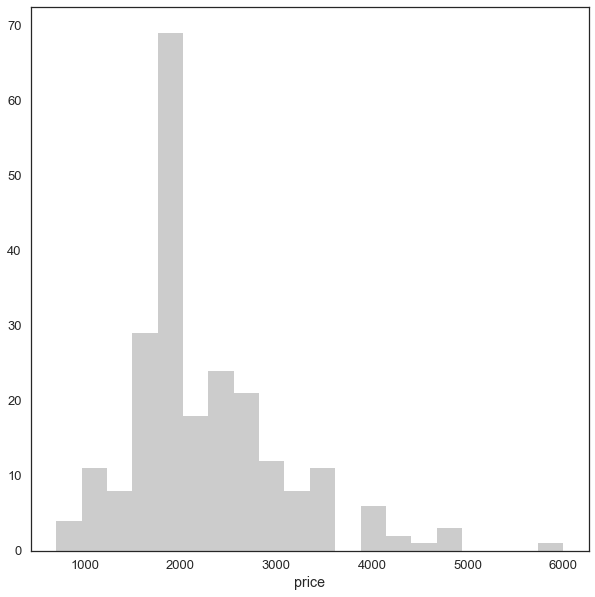

In [26]:
plt.figure(figsize=(10,10))
sns.distplot(df['price'], bins=20, kde=False, color="gray")

In [27]:
df.head()

,location,name,price,space,latitude,longitude,price_cat,dist_to_center,shop_dist,shop_type
1,"Lublin, Czechów Górny",Wyremontowane 2 pok. mieszkanie Chodźki blisko Um,1500.0,50.0,51.263611,22.539445,cat_2,2424.0,847.0,lidl
6,"Lublin, Śródmieście, Spokojna",Ekskluzywny apartament w centrum miasta,3300.0,93.0,51.250317,22.553738,cat_5,900.0,668.0,zabka
9,Lublin,"Kawalerka na wynajem- 700 zł/ m-c, umeblowana",700.0,21.0,51.250559,22.570102,cat_1,246.0,191.0,zabka
13,"Lublin, Tatary, Gospodarcza",Dwupokojowe mieszkanie Lublin Tatary,900.0,34.0,51.243457,22.597870,cat_1,2290.0,91.0,zabka
15,"Lublin, Śródmieście","Mieszkanie, 28 m², Lublin",1000.0,28.0,51.247235,22.555546,cat_1,833.0,344.0,zabka


In [28]:
df = df.loc[df['price'] <= 2500]
df = df.loc[df['price'] >= 1200]
df = df.loc[df['space'] >= 40]
df.describe()

,price,space,latitude,longitude,dist_to_center,shop_dist
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,1912.919118,58.049706,51.255390,22.554019,1818.992647,531.955882
std,320.572452,12.598792,0.010182,0.018061,818.382619,232.197996
min,1200.000000,40.000000,51.232070,22.526111,142.000000,48.000000
25%,1700.000000,50.000000,51.247568,22.537197,1134.750000,347.000000
50%,1900.000000,55.000000,51.256385,22.555546,2030.000000,540.000000
75%,2100.000000,65.150000,51.262695,22.568012,2438.250000,713.000000
max,2500.000000,100.000000,51.274346,22.592500,2953.000000,999.000000


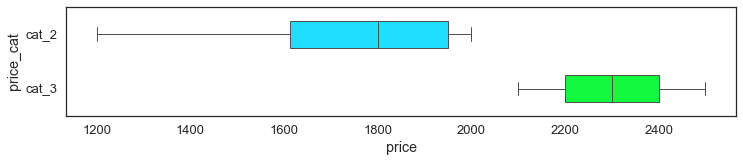

In [29]:
plt.figure(figsize=(12,2))
sns.boxplot(x="price", y="price_cat", data=df,width=0.5,
            linewidth=1,fliersize=0.0,palette=[colors[1],colors[2]],
            saturation=1,orient="h",
            order=["cat_2","cat_3"]
           )

In [30]:
df.groupby(['price_cat']).size()

price_cat
cat_2    98
cat_3    38
dtype: int64